This is a notebook to analyze the "closed" structures we have, mainly for the paper.

In [14]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import scienceplots

In [15]:
# Set the default style
plt.style.use('science')

We will look at the experimental structures for each protein that our AlphaFold structures come closest to. We can use that to assign state to the structures. We will then look at the distributions of the RMSDs of all of the closed structures for each protein, to make sure nothing is too off.

In [16]:
# Import our data
df = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')

print(len(df))
df.head()

894


,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.000000,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.000000,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN
2,P00523,2ptk,"148-245,246-266","81-142,521-533",1.737,100.0,89.333333,1.921,3.093,Autoinhibited,Closed,Gallus gallus,['1997-06-17'],NaN
3,P28482,1pme,173-196,"25-172,197-313",2.422,100.0,96.603774,1.220,6.639,Autoinhibited,Closed,Homo sapiens,['1998-06-08'],NaN
4,P28482,1tvo,173-196,"25-172,197-313",2.497,100.0,100.000000,1.523,6.633,Autoinhibited,Closed,Homo sapiens,['2004-06-30'],NaN


In [17]:
# Get the minimum value for each protein

df_min = df.groupby('uniprot')['2_comp'].min().reset_index()

df_min = pd.merge(df_min, df, on=['uniprot', '2_comp'], how='inner').drop_duplicates(subset='uniprot', keep='first')

# Get rid of our actin outliers
df_min = df_min[df_min['2_comp'] < 100]

print(len(df_min))

126


In [18]:
# Figure out which AlphaFold2 proteins are in the active state

closed_af = df_min[df_min['state'] == 'Active']

closed_uniprot = closed_af['uniprot'].unique()

print(len(closed_uniprot))
# Subset our original dataframe to these proteins and only include the closed experimental structures
closed = df[df['uniprot'].isin(closed_uniprot)]

closed = closed[closed['state'] == 'Active']

print(len(closed))
closed.head()

27
169


,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes
26,P28482,4qp2,173-196,"25-172,197-313",1.729,75.000000,98.490566,1.321,3.241,Active,Closed,Homo sapiens,['2014-06-22'],NaN
27,P28482,4qp3,173-196,"25-172,197-313",1.817,75.000000,98.490566,1.348,3.391,Active,Closed,Homo sapiens,['2014-06-22'],NaN
28,P28482,4qp4,173-196,"25-172,197-313",1.956,66.666667,100.000000,1.490,3.991,Active,Closed,Homo sapiens,['2014-06-22'],NaN
29,P28482,4qp6,173-196,"25-172,197-313",1.856,75.000000,98.490566,1.387,3.309,Active,Closed,Homo sapiens,['2014-06-22'],NaN
30,P28482,4qp7,173-196,"25-172,197-313",1.928,66.666667,100.000000,1.426,3.994,Active,Closed,Homo sapiens,['2014-06-22'],NaN


Let's look at the distribution of our scores.

First for only the lowest scores.

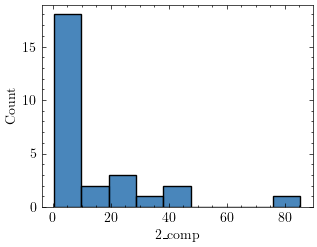

In [19]:
sns.histplot(closed_af, x='2_comp')

plt.show()

Now for all of our scores.

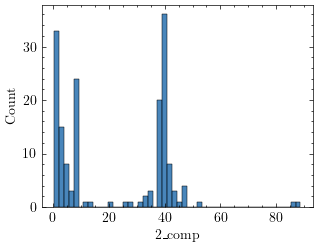

In [20]:
sns.histplot(data=closed, x='2_comp', bins=50)

plt.show()

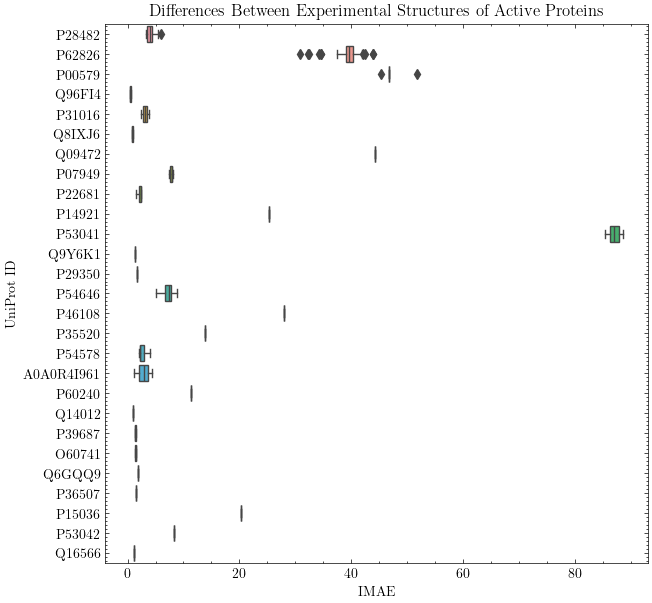

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.boxplot(data=closed, x='2_comp', y='uniprot', ax=ax)
ax.set_xlabel('IMAE')
ax.set_ylabel('UniProt ID')
ax.set_title('Differences Between Experimental Structures of Active Proteins')

plt.savefig('./project_pipeline/data/figures/active_exp_structure_spreads.png')
plt.show()

We'll conduct a paired samples t-test.

In [22]:
x = closed_af['2_comp']
y = closed['2_comp']

result = mannwhitneyu(x, y)
print(result)

MannwhitneyuResult(statistic=1556.5, pvalue=0.008117677456704882)


Repeat with autoinhibitory proteins

In [23]:

auto_af = df_min[df_min['state'] == 'Autoinhibited']

auto_uniprot = auto_af['uniprot'].unique()

print(len(auto_uniprot))
# Subset our original dataframe to these proteins and only include the autoinhibited experimental structures
auto = df[df['uniprot'].isin(auto_uniprot)]

auto = auto[auto['state'] == 'Autoinhibited']

print(len(auto))
auto.head()

60
249


,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes
0,P04637,8f2h,364-393,102-292,30.431,100.000000,100.000000,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN
1,P04637,8f2i,364-393,102-292,30.431,100.000000,100.000000,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN
2,P00523,2ptk,"148-245,246-266","81-142,521-533",1.737,100.000000,89.333333,1.921,3.093,Autoinhibited,Closed,Gallus gallus,['1997-06-17'],NaN
230,P43405,4fl2,"93-167,245-370",371-631,2.146,64.179104,100.000000,2.747,1.579,Autoinhibited,Closed,Homo sapiens,['2012-06-14'],NaN
231,P43405,4fl3,"93-167,245-370",371-631,1.035,61.194030,95.019157,0.822,1.189,Autoinhibited,Closed,Homo sapiens,['2012-06-14'],NaN


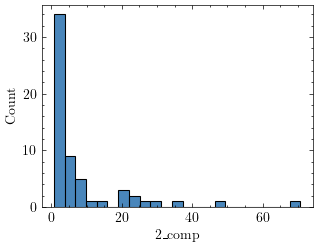

In [24]:
sns.histplot(auto_af, x='2_comp')

plt.show()

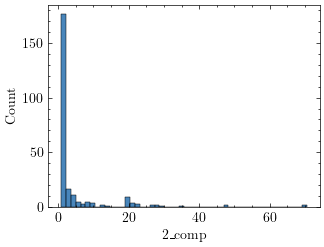

In [25]:
sns.histplot(data=auto, x='2_comp', bins=50)

plt.show()

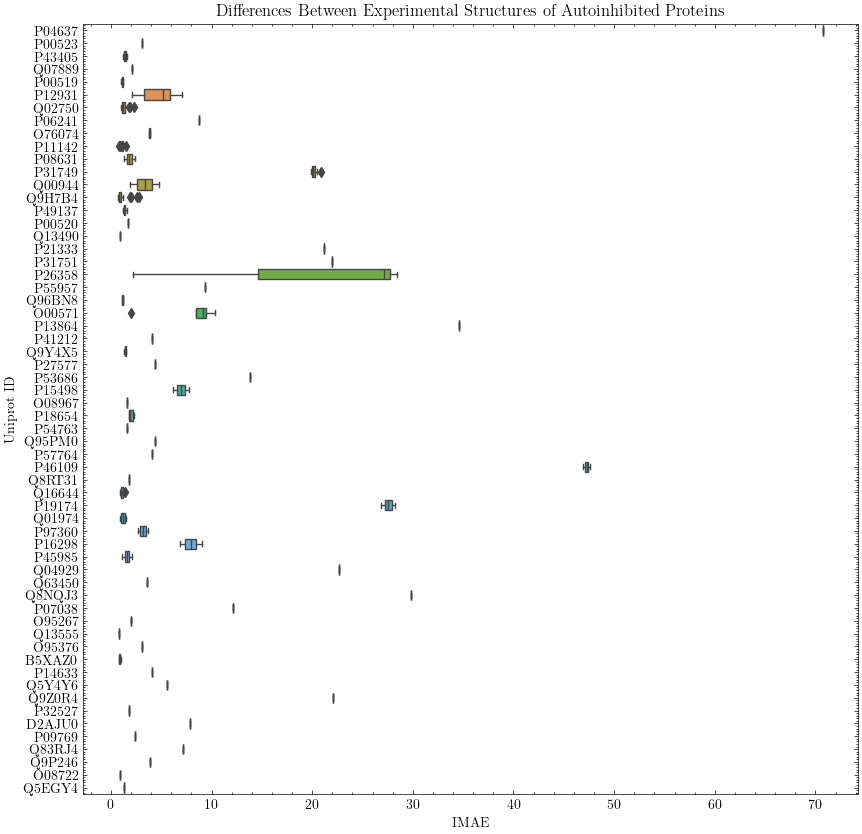

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.boxplot(data=auto, x='2_comp', y='uniprot', ax=ax)
ax.set_xlabel('IMAE')
ax.set_ylabel('Uniprot ID')
ax.set_title('Differences Between Experimental Structures of Autoinhibited Proteins')

plt.savefig('./project_pipeline/data/figures/auto_exp_structure_spreads.png', dpi=500, bbox_inches='tight')
plt.show()